In [1]:
import torch

In [2]:
dataset = "CIFAR10" # ImageNet, MNIST, FashionMNIST, CIFAR10


# load data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


# get RandAugment from torchvision
import torchvision
rand_augment = torchvision.transforms.RandAugment(num_ops=4, magnitude=9)
if 0:
    # get augmentation for training (crop, flip, color jitter)
    augment = transforms.Compose([#transforms.RandomCrop(resolution, padding=4, padding_mode="reflect"),
                                    transforms.RandomHorizontalFlip(p=0.4),
                                    transforms.ToTensor(),
                                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                            ])


train_data, val_data, test_data = None, None, None
if dataset == "ImageNet":
    num_classes = 1000
    resolution = 224
    n_channels = 3
    transform = transforms.Compose([transforms.Resize(resolution), transforms.ToTensor(), 
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    train_transform = transforms.Compose([rand_augment, transforms.Resize(resolution), transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    dev_data = datasets.ImageNet(root="data", split="train", download=True, transform=transform)
    val_data = datasets.ImageNet(root="data", split="val", download=True, transform=transform)
    test_data = datasets.ImageNet(root="data", split="val", download=True, transform=transform)

elif dataset == "MNIST" or dataset == "FashionMNIST":
    num_classes = 10
    resolution = 28
    n_channels = 1
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
    train_transform = transforms.Compose([rand_augment, transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    if dataset == "MNIST":
        dev_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
        test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    else:
        dev_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
        test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

elif dataset == "CIFAR10":
    num_classes = 10
    resolution = 32
    n_channels = 3
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ])
    train_transform = transforms.Compose([rand_augment, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dev_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
# define conv net
class ConvNet(torch.nn.Module):
    def __init__(self, num_classes, n_channels, resolution):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(n_channels, 32, 3, 1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1, padding=1)
        self.dropout1 = torch.nn.Dropout2d(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(resolution**2 // 4 * 64, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)        


    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output

In [4]:
from numpy import pad


test_in = torch.rand(1, n_channels, resolution, resolution)
conv1 = torch.nn.Conv2d(n_channels, 32, 3, 1, padding=1)
out = conv1(test_in)
print(out.shape)

torch.Size([1, 32, 32, 32])


In [5]:
import torch

if val_data is None:
    # split dev data into train and validation
    train_size = int(0.8 * len(dev_data))
    val_size = len(dev_data) - train_size
    train_data, val_data = torch.utils.data.random_split(dev_data, [train_size, val_size])

# split train data into train and generalization
gen_size = int(0.8 * len(train_data))
train_size = len(train_data) - gen_size
train_data, gen_data = torch.utils.data.random_split(train_data, [train_size, gen_size])
# set train transform
train_data.dataset.transform = train_transform

In [6]:
resolution * resolution * 64 // 2

32768

In [7]:
# test conv net
model = ConvNet(num_classes, n_channels, resolution)
input_data = torch.randn(1, n_channels, resolution, resolution)
output = model(input_data)
print(output)
pred = output.argmax(dim=1, keepdim=True)
print(pred)

tensor([[-2.4015, -2.1762, -2.2661, -2.2782, -2.2607, -2.4354, -2.3990, -2.1852,
         -2.3532, -2.3067]], grad_fn=<LogSoftmaxBackward0>)
tensor([[1]])


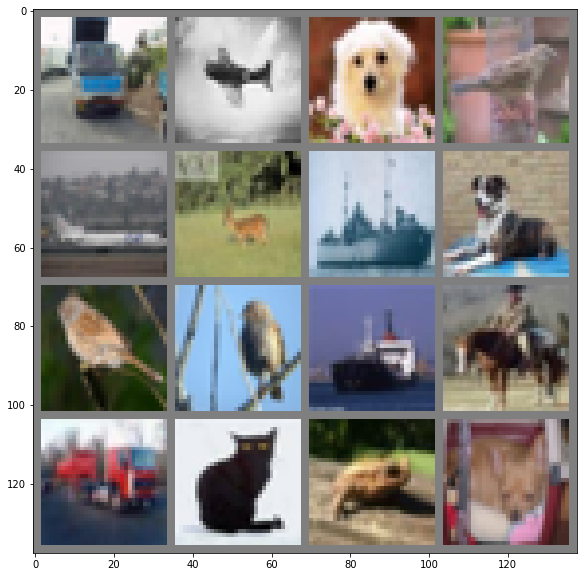

In [8]:
# test training augmentation by plotting some images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dl = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
dataiter = iter(dl)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(images, nrow=4))

In [9]:
images.shape

torch.Size([16, 3, 32, 32])

In [30]:
# train loss function
def train_loss(model, data, target):
    output = model(data)
    loss = torch.nn.functional.nll_loss(output, target)
    return loss


import copy


# define train2generalize loss function
def train2generalize(model, data, target, gen_loader, optimizer, reset_net=False, **kwargs):
    # train for one step, then test on one generalization data batch and backprop

    # save current model parameters
    if reset_net:
        model_params = copy.deepcopy(model.state_dict())        

    # update weights
    loss = train_loss(model, data, target)
    optimizer.zero_grad()
    loss.backward(create_graph=True)
    optimizer.step()

    # test on one generalization data batch
    gen_data, gen_target = next(iter(gen_loader))
    gen_data, gen_target = gen_data.to(device), gen_target.to(device)
    gen_loss = train_loss(model, gen_data, gen_target)

    optimizer.zero_grad()

    if reset_net:
        # reset model parameters to only make use of second order information
        # restore model parameters by subtracting the difference between the current and saved parameters
        for param, saved_param in zip(model.parameters(), model_params.values()):
            param.data -= param.data - saved_param.detach()

    return gen_loss


def train2generalize2(model, data, target, gen_loader, optimizer, fast_net, inner_lr=0.001, **kwargs):
    #print(data.device, target.device, model.fc1.weight.device)
    loss_fast = train_loss(model, data, target)
    grad = torch.autograd.grad(loss_fast, model.parameters(), create_graph=True)
    fast_weights = list(map(lambda p: p[1] - inner_lr * p[0], zip(grad, model.parameters())))

    # load fast weights into fast_net
    fast_net.load_state_dict(dict(zip(fast_net.state_dict().keys(), fast_weights)))
    # print grad of fast_net to check if it is the same as grad
    print("grad", grad[0][0,0,0,0])
    print("fast_net", fast_net.conv1.weight.grad[0,0,0,0])
    gen_data, gen_target = next(iter(gen_loader))
    gen_data, gen_target = gen_data.to(device), gen_target.to(device)

    loss_gen = train_loss(fast_net, gen_data, gen_target)
    return loss_gen


def train2generalize_with_l2l(model, data, target, gen_loader, optimizer, fast_net, inner_lr=0.001, **kwargs):
    import learn2learn as l2l
    maml = l2l.algorithms.MAML(model, lr=inner_lr)
    for iteration in range(1):
        optimizer.zero_grad()
        task_model = maml.clone()  # torch.clone() for nn.Modules
        adaptation_loss = train_loss(task_model, data, target)
        task_model.adapt(adaptation_loss)  # computes gradient, update task_model in-place

        gen_data, gen_target = next(iter(gen_loader))
        gen_data, gen_target = gen_data.to(device), gen_target.to(device)
        evaluation_loss = train_loss(task_model, gen_data, gen_target)
    return evaluation_loss
   

def train2generalize_with_higher(model, data, target, gen_loader, optimizer, fast_net, inner_lr=0.001, **kwargs):
    import higher
    # When you want to branch from the current state of your model and unroll
    # optimization, follow this example. This context manager gets a snapshot of the
    # current version of the model and optimizer at the point where you want to
    # start unrolling and create a functional version `fmodel` which executes the
    # forward pass of `model` with implicit fast weights which can be read by doing
    # `fmodel.parameters()`, and a differentiable optimizer `diffopt` which ensures
    # that at each step, gradient of `fmodel.parameters()` with regard to initial
    # fast weights `fmodel.parameters(time=0)` (or any other part of the unrolled
    # model history) is defined.
    n_inner_iter = 1
    inner_opt = torch.optim.SGD(model.parameters(), lr=inner_lr)

    with higher.innerloop_ctx(model, inner_opt, copy_initial_weights=False) as (fmodel, diffopt):
        for _ in range(n_inner_iter):
            logits = fmodel(data)  # modified `params` can also be passed as a kwarg
            loss = torch.nn.functional.nll_loss(logits, target)
            # no need to call loss.backwards()
            diffopt.step(loss)  # note that `step` must take `loss` as an argument!
        # The final set of adapted parameters will induce some
        # final loss and accuracy on the query dataset.
        # These will be used to update the model's meta-parameters.


        # At this point, or at any point in the iteration, you can take the
        # gradient of `fmodel.parameters()` (or equivalently
        # `fmodel.fast_params`) w.r.t. `fmodel.parameters(time=0)` (equivalently
        # `fmodel.init_fast_params`). i.e. `fast_params` will always have
        # `grad_fn` as an attribute, and be part of the gradient tape.

        # At the end of your inner loop you can obtain these e.g. ...
        #grad_of_grads = torch.autograd.grad(
        #    meta_loss_fn(fmodel.parameters()), fmodel.parameters(time=0))
        gen_data, gen_target = next(iter(gen_loader))
        gen_data, gen_target = gen_data.to(device), gen_target.to(device)
        eval_loss = train_loss(fmodel, gen_data, gen_target)
    return eval_loss

import time

# define train function
def train(model, device, train_loader, optimizer, epoch, use_train2generalize=False, gen_loader=None, train_to_generalize_kwargs=None, 
         save_graph=False):
    model.train()

    if use_train2generalize:
        fast_net = copy.deepcopy(model).to(device)

    start_time = time.time()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        if use_train2generalize:
            if train_to_generalize_kwargs["use_l2l"]:
                loss = train2generalize_with_l2l(model, data, target, gen_loader, optimizer, fast_net, **train_to_generalize_kwargs)
            elif train_to_generalize_kwargs["use_higher"]:
                loss = train2generalize_with_higher(model, data, target, gen_loader, optimizer, fast_net, **train_to_generalize_kwargs)
            else:
                loss = train2generalize(model, data, target, gen_loader, optimizer, **train_to_generalize_kwargs)
        else:
            loss = train_loss(model, data, target)

        if batch_idx == 0 and save_graph:
            # visualize comp graph
            from torchviz import make_dot
            make_dot(loss).render("comp_graph", format="png")
            # print GPU memory usage with torch in GB
            print("GPU memory usage: ", torch.cuda.memory_allocated(device)/1e9, "GB")
            #print(torch.cuda.memory_summary(device=None, abbreviated=False))



        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()), 
        f"Time: {time.time() - start_time:.2f}s")


# define test function
@torch.inference_mode()
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)')

# define hyperparameters
use_train2generalize = 0
epochs = 10
train_to_generalize_kwargs = {'reset_net': 1,
                              'inner_lr': 0.001,
                              'use_l2l': 0,
                              'use_higher': 0,
                              'use_MLPT': 0,  # for real MLPT we need to include the first loss term too and we need to use half the batch size (divide a batch into two tasks)
                              }
batch_size = 128
lr = 0.001


# define train and test data loaders
from torch.utils.data import DataLoader, ConcatDataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
gen_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=True)
# create loader that combine train and generalization data
train_gen_loader = DataLoader(ConcatDataset([train_data, gen_data]), batch_size=batch_size, shuffle=True)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define model
model = ConvNet(num_classes, n_channels, resolution).to(device)
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
 
# train model
if use_train2generalize and not train_to_generalize_kwargs["use_MLPT"]:
    used_train_loader = train_loader
else:
    used_train_loader = train_gen_loader
if train_to_generalize_kwargs["use_MLPT"]:
    used_gen_loader = train_gen_loader
else:
    used_gen_loader = gen_loader


test(model, device, val_loader)
for epoch in range(1, epochs + 1):
    save_graph = epoch == 1
    train(model, device, train_loader, optimizer, epoch, use_train2generalize=use_train2generalize, 
          gen_loader=gen_loader, train_to_generalize_kwargs=train_to_generalize_kwargs, save_graph=save_graph)
    test(model, device, val_loader)

Average loss: 2.3021, Accuracy: 998/10000 (9.98%)
GPU memory usage:  0.28544256 GB
Train Epoch: 1 [3968/8000 (98%)]	Loss: 1.749561 Time: 1.27s
Average loss: 1.5912, Accuracy: 4436/10000 (44.36%)
Train Epoch: 2 [3968/8000 (98%)]	Loss: 1.507016 Time: 1.18s
Average loss: 1.4176, Accuracy: 4905/10000 (49.05%)
Train Epoch: 3 [3968/8000 (98%)]	Loss: 1.463536 Time: 1.19s
Average loss: 1.3393, Accuracy: 5243/10000 (52.43%)
Train Epoch: 4 [3968/8000 (98%)]	Loss: 1.490555 Time: 1.19s
Average loss: 1.2903, Accuracy: 5320/10000 (53.20%)
Train Epoch: 5 [3968/8000 (98%)]	Loss: 1.374571 Time: 1.19s
Average loss: 1.2321, Accuracy: 5641/10000 (56.41%)
Train Epoch: 6 [3968/8000 (98%)]	Loss: 1.235907 Time: 1.22s
Average loss: 1.2200, Accuracy: 5662/10000 (56.62%)
Train Epoch: 7 [3968/8000 (98%)]	Loss: 1.084495 Time: 1.21s
Average loss: 1.2141, Accuracy: 5638/10000 (56.38%)
Train Epoch: 8 [3968/8000 (98%)]	Loss: 1.165869 Time: 1.18s
Average loss: 1.1778, Accuracy: 5851/10000 (58.51%)
Train Epoch: 9 [3968/

In [31]:
# test model
test(model, device, test_loader)

Average loss: 1.1764, Accuracy: 5836/10000 (58.36%)


In [29]:
# test model
test(model, device, test_loader)

Average loss: 1.0624, Accuracy: 6252/10000 (62.52%)


In [24]:
# test model
test(model, device, test_loader)

Average loss: 1.1853, Accuracy: 5815/10000 (58.15%)


In [22]:
# test model
test(model, device, test_loader)

Average loss: 1.0776, Accuracy: 6159/10000 (61.59%)


In [20]:
# test model
test(model, device, test_loader)

Average loss: 1.1043, Accuracy: 6051/10000 (60.51%)


In [18]:
# test model
test(model, device, test_loader)

Average loss: 1.1215, Accuracy: 5991/10000 (59.91%)


In [16]:
# test model
test(model, device, test_loader)

Average loss: 1.1870, Accuracy: 5877/10000 (58.77%)
